In [162]:
# Algorithm to find the order of a function (the one and only Shor's algorithm)

import numpy as np
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *

# Loading your IBM Q account(s)
provider = IBMQ.load_account()

ibmqfactory.load_account:WARNING:2021-05-21 06:14:04,445: Credentials are already in use. The existing account in the session will be replaced.


In [163]:
provider = IBMQ.providers()[0]

In [164]:
provider.backends()

[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmqx2') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_16_melbourne') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_armonk') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_athens') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_santiago') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_lima') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_belem') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_quito') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_statevector') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_mps') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_extended_stabilizer') fr

In [165]:
backend = provider.get_backend('simulator_mps')
backend

<IBMQSimulator('simulator_mps') from IBMQ(hub='ibm-q', group='open', project='main')>

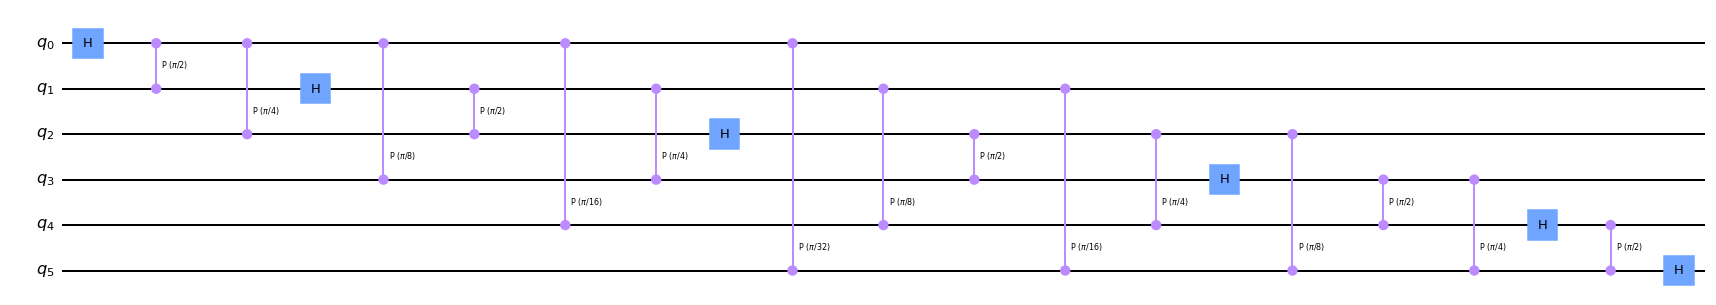

In [166]:
# The modular gate implementation. Calculates addition of x and a for a fixed a and variable x, mod N.
# But first the Quantum Fourier transform
import math

n = 6
QFT = QuantumCircuit(n)
for i in range(n):
    QFT.h(i)
    for j in range(2, n - i + 1):
        QFT.cp((2 * math.pi) / (2**j), i + j - 1, i)

QFT.draw(fold=-1)

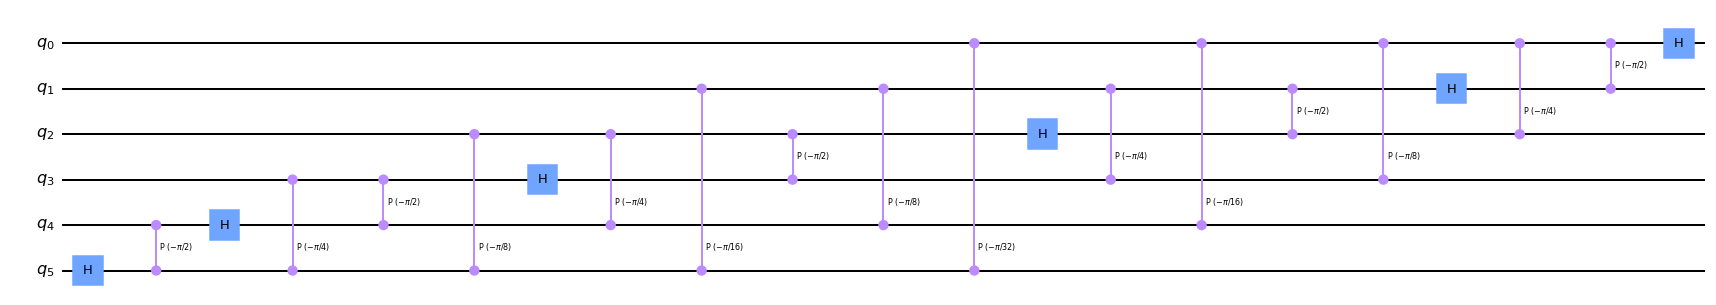

In [167]:
InvQFT = QFT.inverse()
InvQFT.draw(fold=-1)

In [168]:
# need a definition for the creation of this QFT circuit for a general bit input
def QFTSyn(n):
    QFT = QuantumCircuit(n)
    for i in range(n):
        QFT.h(i)
        for j in range(2, n - i + 1):
            QFT.cp((2 * math.pi) / (2**j), i + j - 1, i)
    QFTInv = QFT.inverse()
    QFTInv.name = "QFT†"
    QFT.name = "QFT"
    
    return [QFT, QFT.inverse()]

In [169]:
# for a given 'a', find the phase shift, and single qubit gates that apply those phase shifts
# n in the number of bits used in the circuit to represent 'a'
def phaseShift(a, n):
    phaseGates = QuantumCircuit(n)
    # according to the binary equivalent of 'a', calculate the total phase shift
    binA = bin(a)[2:]
    binA = '0' * (n - len(binA)) + binA
    
    for bit in range(n):
        phase = 0.0
        for i in range(n - bit):
            if binA[i + bit] == '1':
                phase += ((2 * math.pi) / (2**(i + 1)))
        phaseGates.p(phase, bit)
    
    phaseGates.name = "phi"
    
    return phaseGates

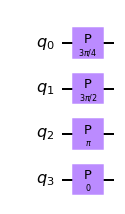

In [170]:
# checking whether giving the correct output or not.
phaseGates = phaseShift(6, 4)
phaseGates.draw(fold=-1)

In [171]:
# I will use only 6 bits but the 7th bit is to prevent overflow
def addition(a, nBits):
    add = QuantumCircuit(nBits + 1)
    
    [QFT, InvQFT] = QFTSyn(nBits + 1)
    phaseGates = phaseShift(a, nBits + 1)
    
    add.compose(QFT, qubits = range(nBits + 1), inplace = True)
    add.compose(phaseGates, qubits= range(nBits + 1), inplace = True)
    add.compose(InvQFT, qubits = range(nBits + 1), inplace = True)
    
    return add

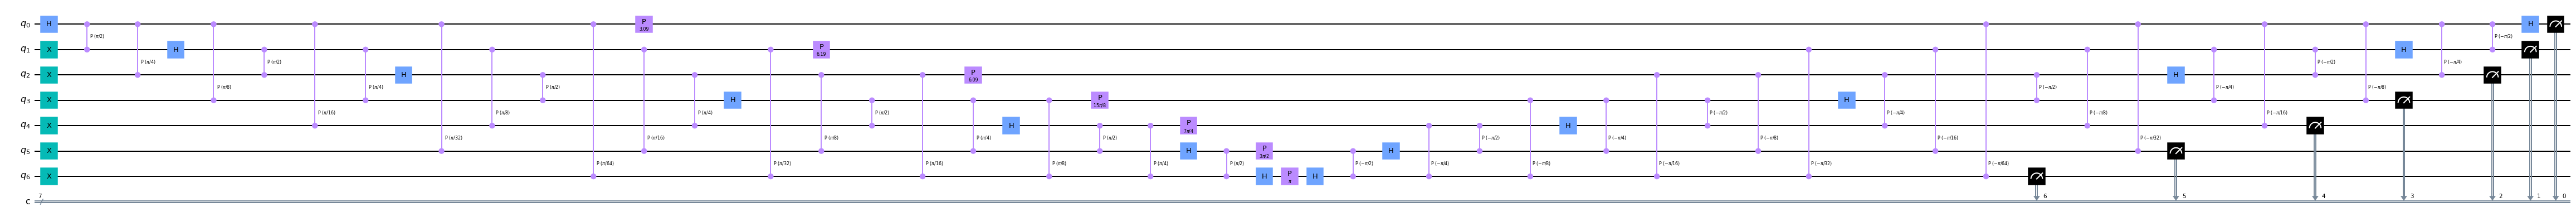

In [172]:
# Checking the addition
nBits = 6
n = 63
a = 63

addTest = QuantumCircuit(nBits + 1, nBits + 1)

# Encoding 63 in the input registers
addTest.x(1)
addTest.x(2)
addTest.x(3)
addTest.x(4)
addTest.x(5)
addTest.x(6)
add = addition(a, nBits)
addTest.compose(add, qubits = range(nBits + 1), inplace = True)
addTest.measure(range(nBits + 1), range(nBits + 1))
addTest.draw(fold = -1)

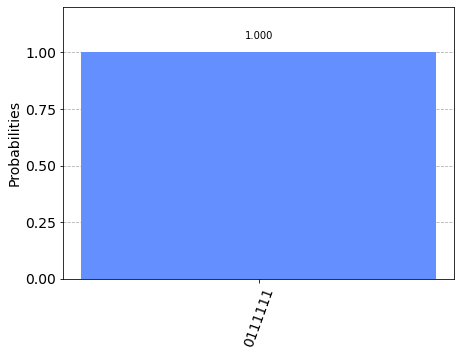

In [173]:
## Yeah, it's running!
counts = backend.run(addTest).result().get_counts()
plot_histogram(counts)

In [174]:
def addModNSyn(nBits, N, a):
    addModNCircuit = QuantumCircuit(nBits + 4)
    
    AddA = phaseShift(a, nBits + 1)
    AddN = phaseShift(N, nBits + 1)
    [QFT, InvQFT] = QFTSyn(nBits + 1)
    
    AddACon = AddA.control(2)
    AddNCon = AddN.control(1)
    AddNCon = AddNCon.decompose()
    AddACon = AddACon.decompose()
    
    addModNCircuit.compose(AddACon, range(nBits + 3), inplace = True)
    addModNCircuit.compose(AddN.inverse(), range(2, nBits + 3), inplace = True)
    addModNCircuit.compose(InvQFT, range(2, nBits + 3), inplace = True)
    addModNCircuit.cx(2, nBits + 3)
    addModNCircuit.compose(QFT, range(2, nBits + 3), inplace = True)
    addModNCircuit.compose(AddNCon, [nBits + 3] + [*range(2, nBits + 3)], inplace = True)
    addModNCircuit.compose(AddACon.inverse(), range(nBits + 3), inplace = True)
    addModNCircuit.compose(InvQFT, range(2, nBits + 3), inplace = True)
    addModNCircuit.x(2)
    addModNCircuit.cx(2, nBits + 3)
    addModNCircuit.x(2)
    addModNCircuit.compose(QFT, range(2, nBits + 3), inplace = True)
    addModNCircuit.compose(AddACon, range(nBits + 3), inplace = True)
    
    return addModNCircuit

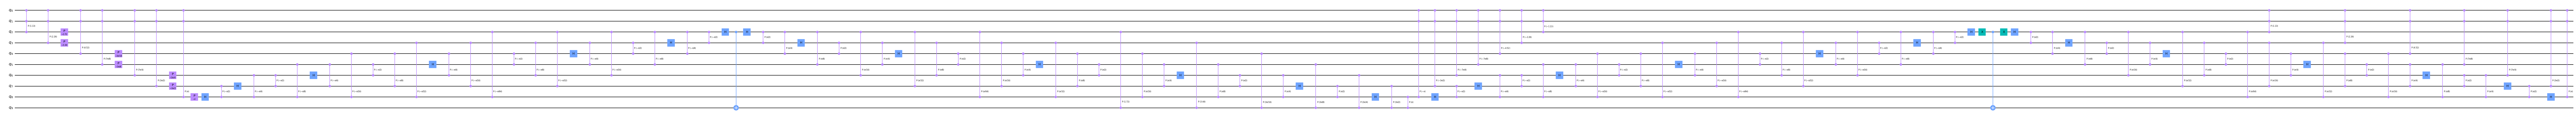

In [175]:
# Now, for the addition modulo operation we need two gates.
nBits = 6
N = 35 # The number we want to factorize. But at least for now, every addition is calculated modulo N.
a = 23

addModNCircuit = addModNSyn(nBits, N, a)
addModNCircuit.draw(fold=-1)
# AddModN = QuantumCircuit(nBits + 1)

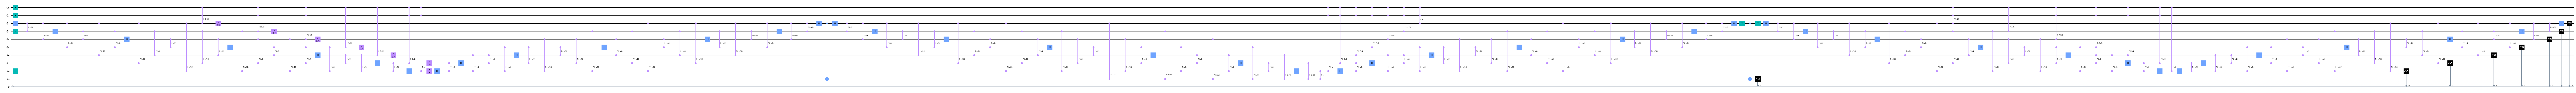

In [176]:
# testing (33 + 23) % 35
addTest = QuantumCircuit(nBits + 4, nBits + 2)
addTest.x(0)
addTest.x(1)
addTest.x(3)
addTest.x(8)
[QFT, InvQFT] = QFTSyn(nBits + 1)
addTest.compose(QFT, range(2, nBits + 3), inplace = True)
addTest.compose(addModNCircuit, range(nBits + 4), inplace = True)
addTest.compose(InvQFT, range(2, nBits + 3), inplace = True)
addTest.measure(range(2, nBits + 4), range(nBits + 2))
addTest.draw(fold=-1)

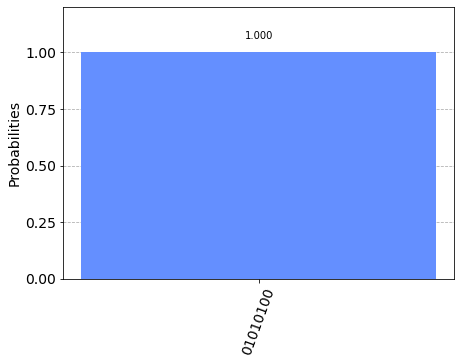

In [179]:
# Yeah, it's done!
addTest = transpile(addTest, backend)
counts = backend.run(addTest).result().get_counts()
plot_histogram(counts)

In [180]:
# for the multiplication operation, we need to create n (add mod N) gates, each with different controller
def multModNSyn(nBits, a, N):
    multModNCircuit = QuantumCircuit(2 * nBits + 3)
    [QFT, InvQFT] = QFTSyn(nBits + 1)
    multModNCircuit.compose(QFT, range(nBits + 1, 2 * nBits + 2), inplace = True)
    for i in range(nBits):
        multModNCircuit.barrier()
        tempGate = addModNSyn(nBits, N, (a * (2**i)) % N)
        multModNCircuit.compose(tempGate, [0, i + 1] + [*range(nBits + 1, 2 * nBits + 3)], inplace = True)
    multModNCircuit.compose(InvQFT, range(nBits + 1, 2 * nBits + 2), inplace = True)
    
    return multModNCircuit

In [181]:
circ = multModNSyn(6, 23, 35)

In [182]:
mulTest = QuantumCircuit(15, 15)
mulTest.x(0)
# encode 23 here
mulTest.x(1)
mulTest.x(2)
mulTest.x(3)
mulTest.x(5)
mulTest.compose(circ, range(15), inplace = True)
mulTest.measure(range(15), range(15))

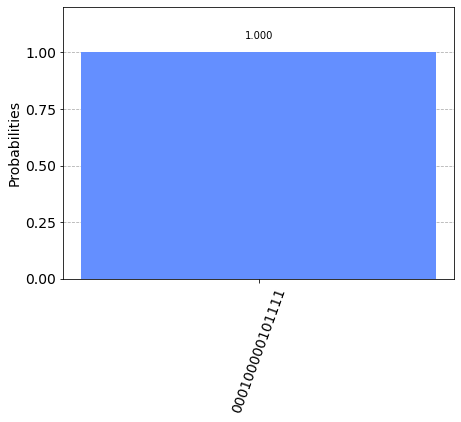

In [185]:
# Calculating (23 * 23) % 35. The answer should be 4, and it is coming out to be 4.
mulTest = transpile(mulTest, backend)
counts = backend.run(mulTest).result().get_counts()
plot_histogram(counts)

In [188]:
## The controlled swap to swap the result to its original position
def CSwap(nBits):
    # The Circuit takes 2 * nBits + 3 inputs
    CSwapCirc = QuantumCircuit(2 * nBits + 3)
    for i in range(nBits):
        # we have to swap the bits at p1 and p2 positions
        tp = nBits + 1
        p1 = (tp - i - 1)
        p2 = (tp + i + 1)
        CSwapCirc.cx(p2, p1)
        CSwapCirc.ccx(0, p1, p2)
        CSwapCirc.cx(p2, p1)
    
    return CSwapCirc

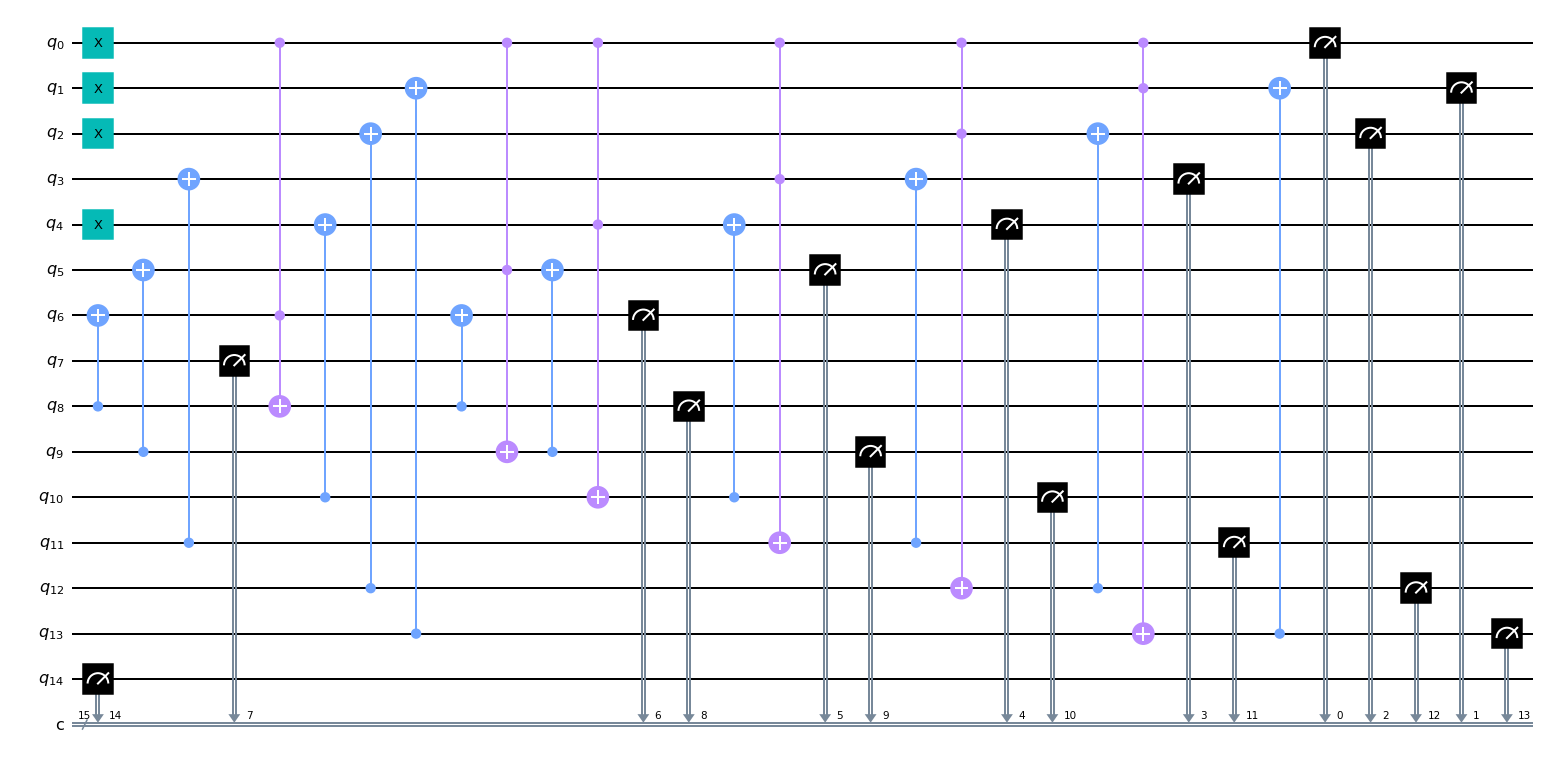

In [189]:
# Testing the controlled swap gate
testSwap = QuantumCircuit(15, 15)
testSwap.x(0)
testSwap.x(1)
testSwap.x(2)
testSwap.x(4)
testSwap.compose(CSwap(6), inplace = True)
testSwap.measure(range(15), range(15))
testSwap.draw(fold=-1)

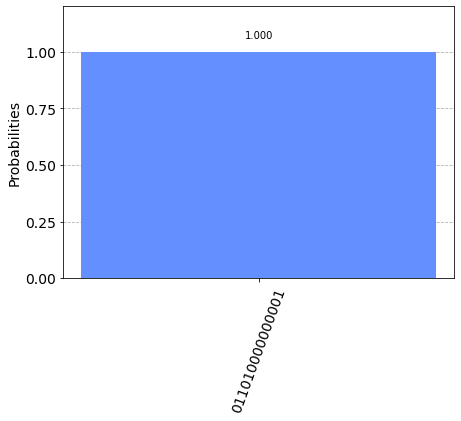

In [190]:
counts = backend.run(testSwap).result().get_counts()
plot_histogram(counts)

In [191]:
# The modular inverse function. Assumes that gcd(a, m) = 1
def modInv(a, m):
    # using the built in function
    return pow(a, -1, m)

In [192]:
## The Controlled U-a gate is constructed from the multiplication modulo N circuit
def CUa(a, nBits, N):
    CUaCircuit = QuantumCircuit(2 * nBits + 3)
    
    multCirc = multModNSyn(nBits, a, N)
    swapCirc = CSwap(nBits)
    multCircInv = multModNSyn(nBits, modInv(a, N), N).inverse()
    
    CUaCircuit.compose(multCirc, inplace = True)
    CUaCircuit.compose(swapCirc, inplace = True)
    CUaCircuit.compose(multCircInv, inplace = True)
    
    return CUaCircuit

In [193]:
# Now, the moment of truth.
CuaCircuit = CUa(23, 6, 35)
testCua = QuantumCircuit(15, 15)
testCua.x(0)
testCua.x(1)
testCua.x(2)
testCua.x(4)
testCua.compose(CuaCircuit, inplace = True)
testCua.measure(range(15), range(15))

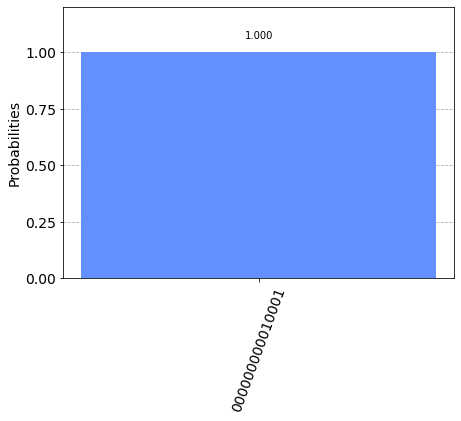

In [194]:
testCua = transpile(testCua, backend)
counts = backend.run(testCua).result().get_counts()
plot_histogram(counts)

In [197]:
# Here starts the Shor's algorithm
def shorCircSyn(nBits, N, a):
    shorCircuit = QuantumCircuit(4 * nBits + 2, 2 * nBits)
    shorCircuit.x(2 * nBits) # Initial value is 1
    
#     pos = 2 * nBits - 1
#     while x != 0:
#         if x % 2 == 1:
#             shorCircuit.x(pos)
#         x //= 2
#         pos -= 1
    
    for i in range(2 * nBits):
        shorCircuit.h(i)
    
    for i in range(2 * nBits):
        tempCUa = CUa(a**(2**i) % N, nBits, N)
        shorCircuit.compose(tempCUa, [2 * nBits - 1 - i] + [*range(2 * nBits, 4 * nBits + 2)], inplace = True)
    
    [QFT, InvQFT] = QFTSyn(2 * nBits)
    
    shorCircuit.compose(InvQFT, range(2 * nBits), inplace = True)
    shorCircuit.measure(range(2 * nBits), range(2 * nBits))
    
    return shorCircuit

In [198]:
shorCircuit = shorCircSyn(6, 35, 8)
# shorCircuit = shorCircuit.decompose()

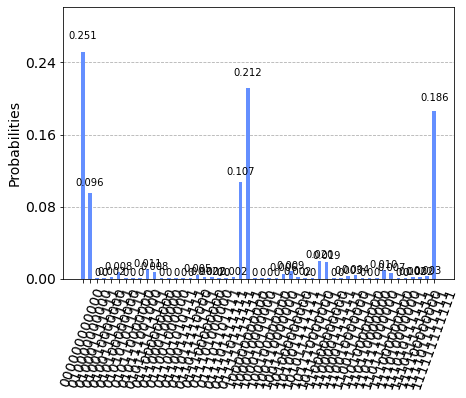

In [199]:
shorCircuit = transpile(shorCircuit, backend)
counts = backend.run(shorCircuit).result().get_counts()
plot_histogram(counts)

In [200]:
import pandas as pd
from fractions import Fraction
rows, measured_phases = [], []
for output in counts:
    decimal = int(output, 2)  # Convert (base 2) string to decimal
    phase = decimal/(2**(2 * nBits))  # Find corresponding eigenvalue
    measured_phases.append(phase)
    # Add these values to the rows in our table:
    rows.append([f"{output}(bin) = {decimal:>3}(dec)", 
                 f"{decimal}/{2**(2 * nBits)} = {phase:.2f}"])
# Print the rows in a table
headers=["Register Output", "Phase"]
df = pd.DataFrame(rows, columns=headers)
print(df)

                  Register Output             Phase
0    000000000000(bin) =   0(dec)     0/4096 = 0.00
1   010000000000(bin) = 1024(dec)  1024/4096 = 0.25
2   010001111111(bin) = 1151(dec)  1151/4096 = 0.28
3   010010000000(bin) = 1152(dec)  1152/4096 = 0.28
4   010011111111(bin) = 1279(dec)  1279/4096 = 0.31
5   010100000000(bin) = 1280(dec)  1280/4096 = 0.31
6   010101011111(bin) = 1375(dec)  1375/4096 = 0.34
7   010110000000(bin) = 1408(dec)  1408/4096 = 0.34
8   010111001000(bin) = 1480(dec)  1480/4096 = 0.36
9   010111111111(bin) = 1535(dec)  1535/4096 = 0.37
10  011000000000(bin) = 1536(dec)  1536/4096 = 0.38
11  011000100000(bin) = 1568(dec)  1568/4096 = 0.38
12  011001000000(bin) = 1600(dec)  1600/4096 = 0.39
13  011001010111(bin) = 1623(dec)  1623/4096 = 0.40
14  011001111111(bin) = 1663(dec)  1663/4096 = 0.41
15  011011110000(bin) = 1776(dec)  1776/4096 = 0.43
16  011011111111(bin) = 1791(dec)  1791/4096 = 0.44
17  011100000000(bin) = 1792(dec)  1792/4096 = 0.44
18  01110100

In [213]:

rows = []
for phase in measured_phases:
    frac = Fraction(phase).limit_denominator(63)
    rows.append([phase, f"{frac.numerator}/{frac.denominator}", frac.denominator])
# Print as a table
headers=["Phase", "Fraction", "R"]
df = pd.DataFrame(rows, columns=headers)
lst = df["R"].to_list()
lst.sort()
for i in lst:
    if ()
print(lst)

[1, 1, 2, 2, 3, 4, 4, 4, 8, 8, 8, 8, 8, 8, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 28, 30, 31, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 36, 41, 47, 47, 51, 53, 53, 53, 57]


In [227]:
# the main factor finding routine. This will use all the implementations above. We want to find the factor of N.
def shorAlgo(N):
    
    # Assumes that N is composite. To make it generally applicable to all numbers, add a prime checking classical algorithm here.
    nBits = len(bin(N)[2:])
    a = 2
    
    while True:
        gd = math.gcd(a, N)
        if gd != 1:
            flag = True
            return [gd, N / gd]
        else:
            shorCircuit = shorCircSyn(nBits, N, a)
            shorCircuit = transpile(shorCircuit, backend)
            counts = backend.run(shorCircuit).result().get_counts()
            lst = []
            for output in counts:
                decimal = int(output, 2)  # Convert binary string to decimal
                phase = decimal / (2**(2 * nBits))  # Find corresponding eigenvalue
                lst.append(Fraction(phase).limit_denominator(2**nBits - 1).denominator)
            lst.sort()
            period = -1
            for r in lst:
                if (a**r) % N == 1:
                    period = r
                    break
            
            if period % 2 != 1 and ((a**(period / 2)) % N) != (N - 1):
                fact1 = math.gcd((a**(int(period / 2)) + 1) % N, N)
                fact2 = N // fact1
                flag = True
                return [fact1, fact2]
        
        a += 1

In [228]:
[a, b] = shorAlgo(91)
print([a, b])

[13, 7]
